In [83]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.signal import savgol_filter

import IPython
import IPython.display

# Read in Processed Data

In [63]:
datapath = '../../OhioT1DM/data/processed/'
train_563 = pd.read_csv(datapath + 'train_563.csv').set_index('ts')
train_588 = pd.read_csv(datapath + 'train_588.csv').set_index('ts')
train_570 = pd.read_csv(datapath + 'train_570.csv').set_index('ts')

test_563 = pd.read_csv(datapath + 'test_563.csv').set_index('ts')
test_588 = pd.read_csv(datapath + 'test_588.csv').set_index('ts')
test_570 = pd.read_csv(datapath + 'test_570.csv').set_index('ts')

In [64]:
all_train_data = [train_563, train_588, train_570]
all_test_data = [test_563, test_588, test_570]

In [65]:
compartmentals = ['Short', 'Long', 'Carb']

# Setup Window Slicing Code

In [66]:
class PredictionRangeGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df, label_columns=None):
        
        # Store data in Generator
        self.train_df = train_df
        self.test_df = test_df
        
        #Work out column indices for different labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='GlucoseLevel', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10, c='#00008B')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        label='Actual', c='#90EE90', edgecolors='k', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          label='Predicted',
                          marker='X', c='#808080', edgecolors='k', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [index]')
        
        
    def make_dataset(self, data, shuffle, batch_size=32):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=batch_size,)
        
        ds = ds.map(self.split_window)
        
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df, True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df, False)
    
    @property
    def example(self):
        """Get and cache an example batch for plotting"""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch found, so get one from train df
            result = next(iter(self.train))
            self._example = result
        return result

# Setup a Baseline to Test Prediction Against

In [67]:
class LinearBaseline(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        """
        Simply returns last value as next value
        """
        return inputs[:, -1, tf.newaxis]

In [68]:
linear_base = LinearBaseline()
linear_base.compile(loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.RootMeanSquaredError()],)

# Setup Windows to be Predicted Over

In [69]:
PREV = 12

In [70]:
fifteen_range = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 3,
    label_columns=['GlucoseLevel'],
    train_df=all_train_data[0],
    test_df=all_test_data[0],
)

fifteen_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 3,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[0]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[0]['GlucoseLevel'])
)

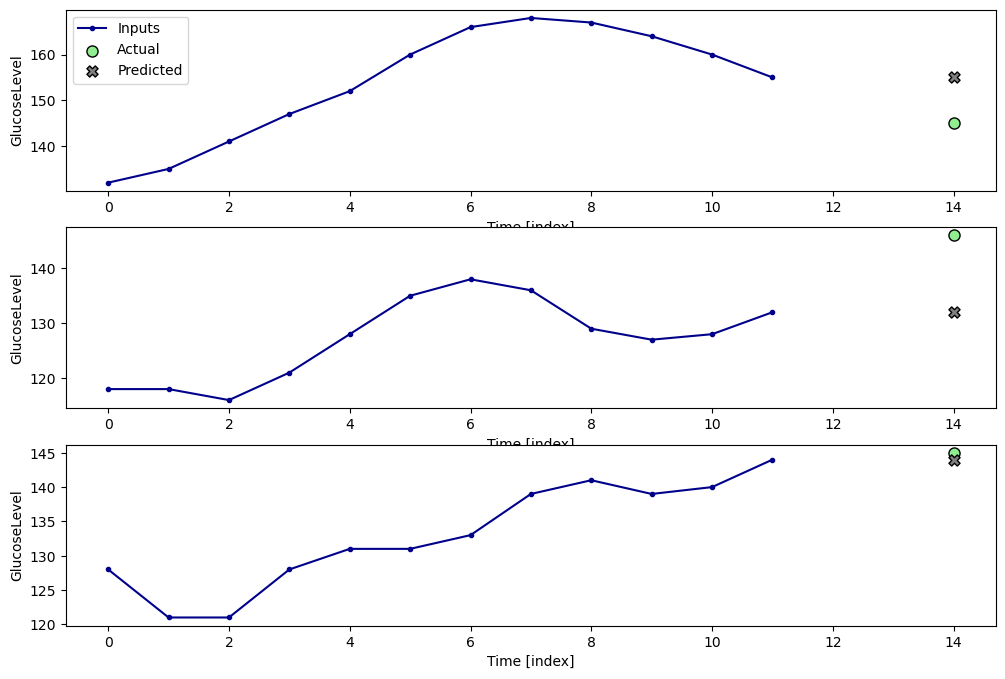

In [71]:
fifteen_range.plot(linear_base)

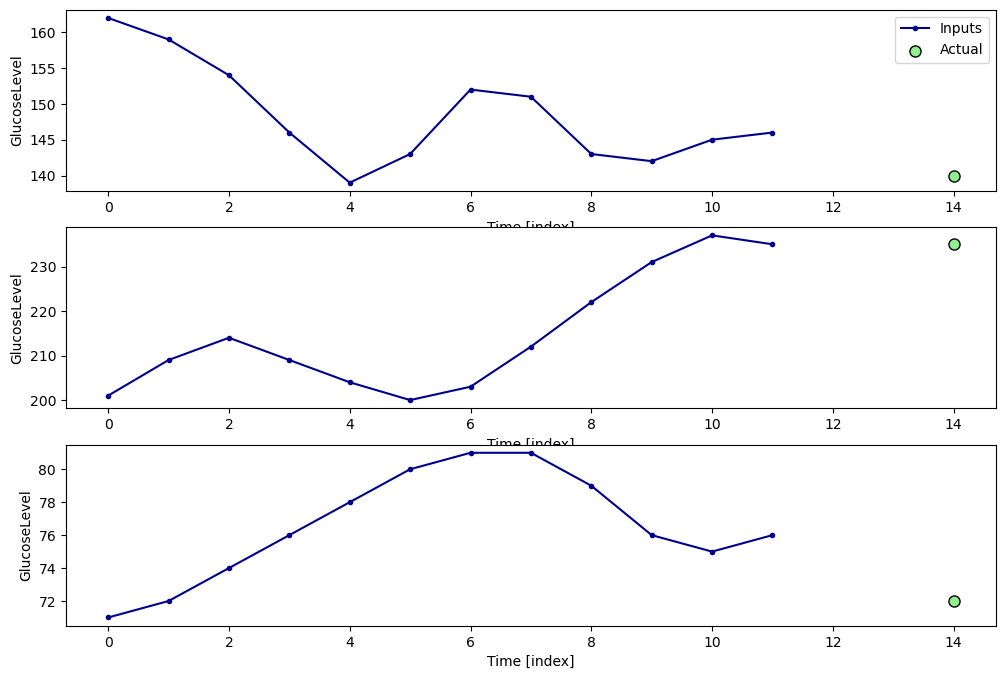

In [72]:
fifteen_range_g.plot()

# Setup Model Training Code

In [73]:
# Setup function to train model on training data

def fit_model(model, predict_range, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError()])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [74]:
def plot_model_predictions(model, pred_range, num_graphs=3):
    all_inputs = np.concatenate([x for x,y  in pred_range.test], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.test], axis=0)
    size = len(all_inputs)
    graph_size = size // num_graphs
    index = 0
    for i in range(num_graphs):
        cur_slice = slice(index, index+graph_size)
        if i == (num_graphs - 1):
            cur_slice = slice(index, size)
        cur_inputs = all_inputs[cur_slice]
        cur_labels = all_labels[cur_slice]
        index += graph_size
        predictions = model(cur_inputs)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(list(range(len(predictions.numpy()))), predictions.numpy().reshape(-1), 'g', linestyle='dashed', label='Predicted')
        plt.plot(list(range(len(cur_labels))), cur_labels.reshape(-1), '-', label='Actual')
        plt.legend()
        plt.show()
    

# Experiment with Different models

## 1. LSTM RNN with CGM Data

### 1.1 Flat Prediction vs Residual Prediction

In [80]:
train_accuracies = {}
test_accuracies = {}

In [ ]:
class ChangeLayer

In [79]:
def create_normal_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([output_length, 1])
    ])

In [76]:
test_lstm = create_normal_lstm(1)
test_lstm_g = create_normal_lstm(1)

In [77]:
print("Input shape: ", fifteen_range.example[0].shape)
print('Output shape:', test_lstm(fifteen_range.example[0]).shape)

Input shape:  (32, 12, 4)
Output shape: (32, 1, 1)


In [78]:
print("Input shape: ", fifteen_range_g.example[0].shape)
print('Output shape:', test_lstm_g(fifteen_range.example[0]).shape)

Input shape:  (32, 12, 1)
Output shape: (32, 1, 1)


In [60]:
fit_model(test_lstm, fifteen_range, 40)
IPython.display.clear_output()

Epoch 1/40
379/379 [==============================] - 8s 14ms/step - loss: 17196.2441 - root_mean_squared_error: 131.1344 - mean_absolute_error: 121.7372
Epoch 2/40
379/379 [==============================] - 6s 15ms/step - loss: 8951.5312 - root_mean_squared_error: 94.6125 - mean_absolute_error: 81.5134
Epoch 3/40
379/379 [==============================] - 5s 14ms/step - loss: 4966.0376 - root_mean_squared_error: 70.4701 - mean_absolute_error: 55.0739
Epoch 4/40
379/379 [==============================] - 5s 14ms/step - loss: 3258.8020 - root_mean_squared_error: 57.0859 - mean_absolute_error: 43.3577
Epoch 5/40
379/379 [==============================] - 7s 18ms/step - loss: 2658.7976 - root_mean_squared_error: 51.5635 - mean_absolute_error: 39.6998
Epoch 6/40
379/379 [==============================] - 8s 21ms/step - loss: 2496.8999 - root_mean_squared_error: 49.9690 - mean_absolute_error: 39.1201
Epoch 7/40
379/379 [==============================] - 8s 22ms/step - loss: 2460.1116 - root

KeyboardInterrupt: 

In [27]:
fit_model(test_lstm_g, fifteen_range_g, 40)
IPython.display.clear_output()

In [42]:
test_lstm.evaluate(fifteen_range.test)

Hello
80/80 [==============================] - 1s 6ms/step - loss: 157.9076 - root_mean_squared_error: 12.5661 - mean_absolute_error: 8.5775


[157.9076385498047, 12.566130638122559, 8.577481269836426]

In [28]:
test_lstm_g.evaluate(fifteen_range_g.test)

Hello
80/80 [==============================] - 1s 3ms/step - loss: 154.0836 - root_mean_squared_error: 12.4130 - mean_absolute_error: 7.6626


[154.08363342285156, 12.413043022155762, 7.662562370300293]

Hello
Hello


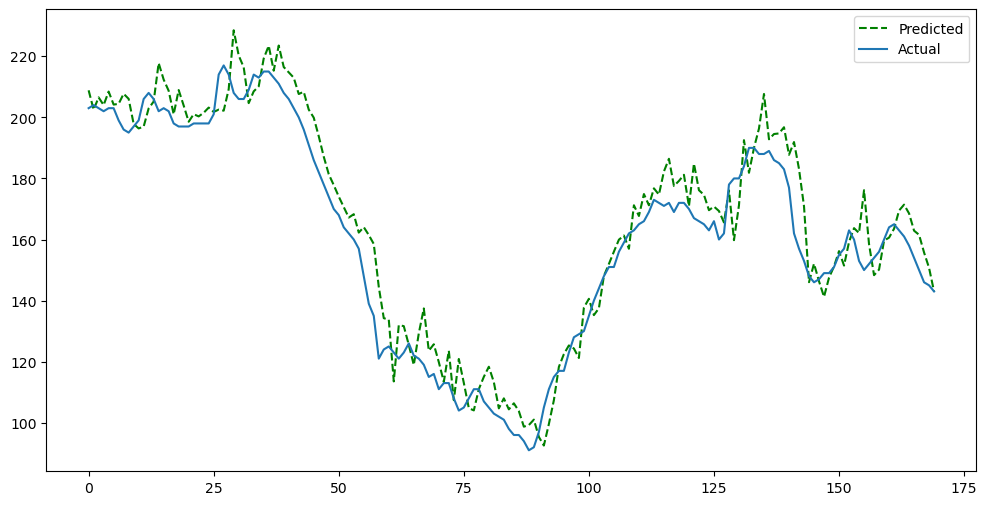

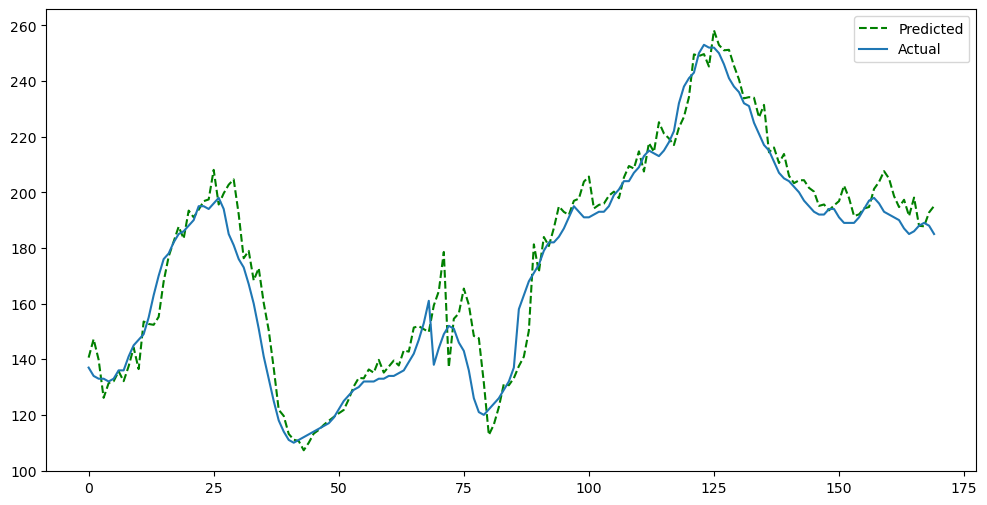

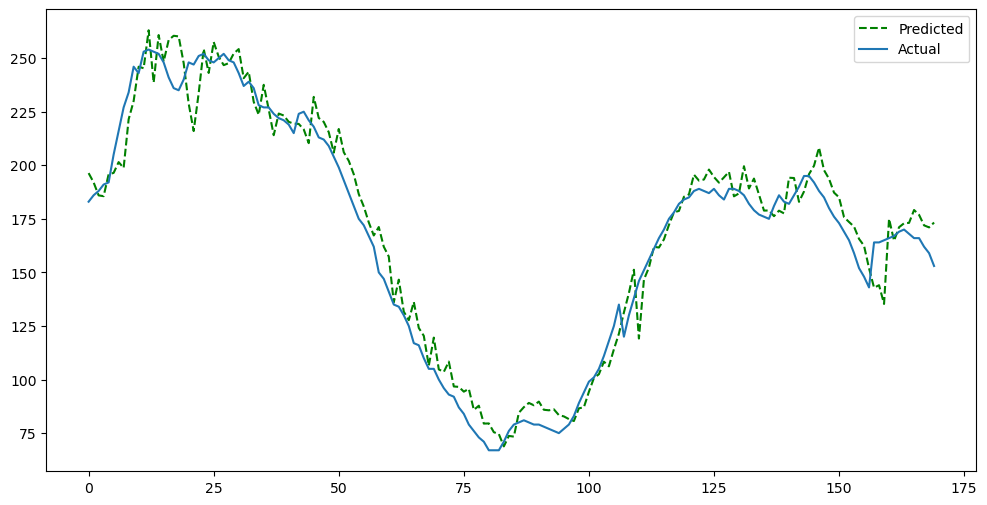

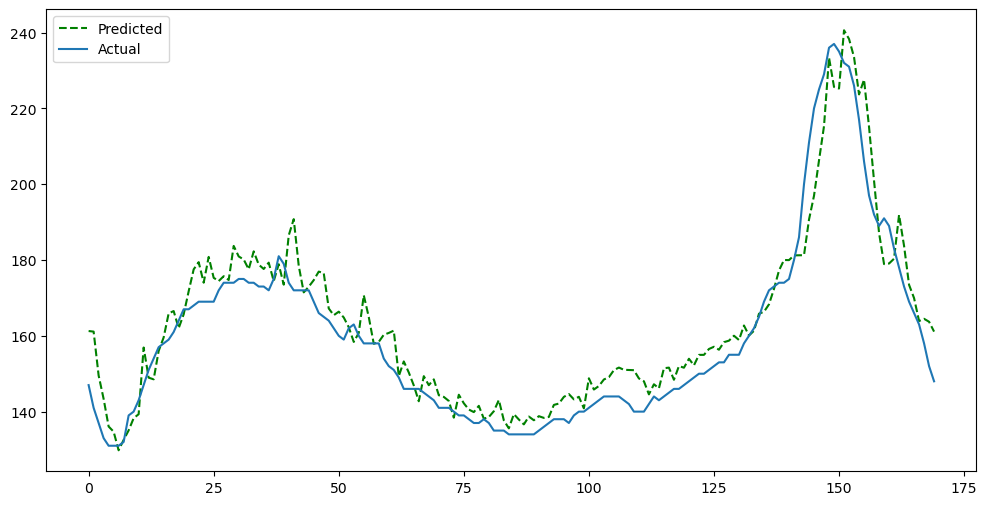

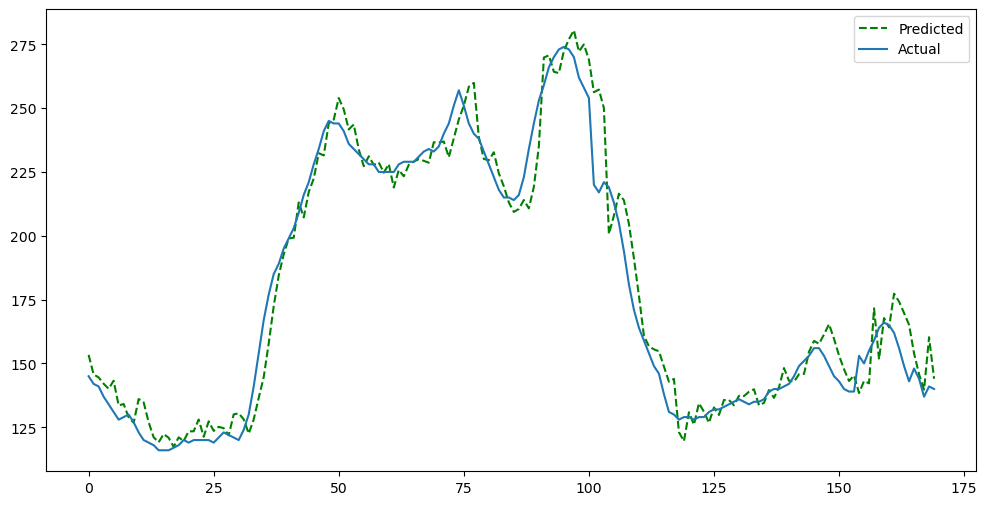

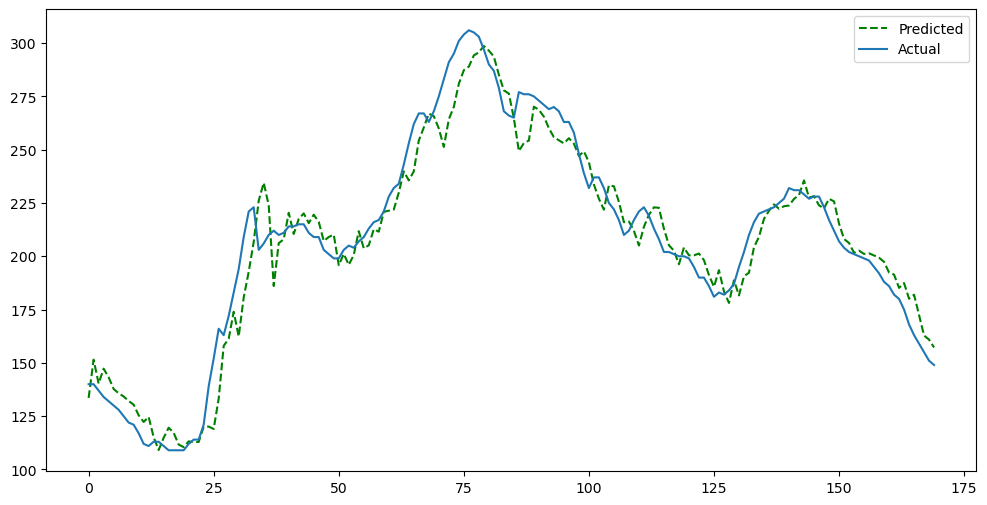

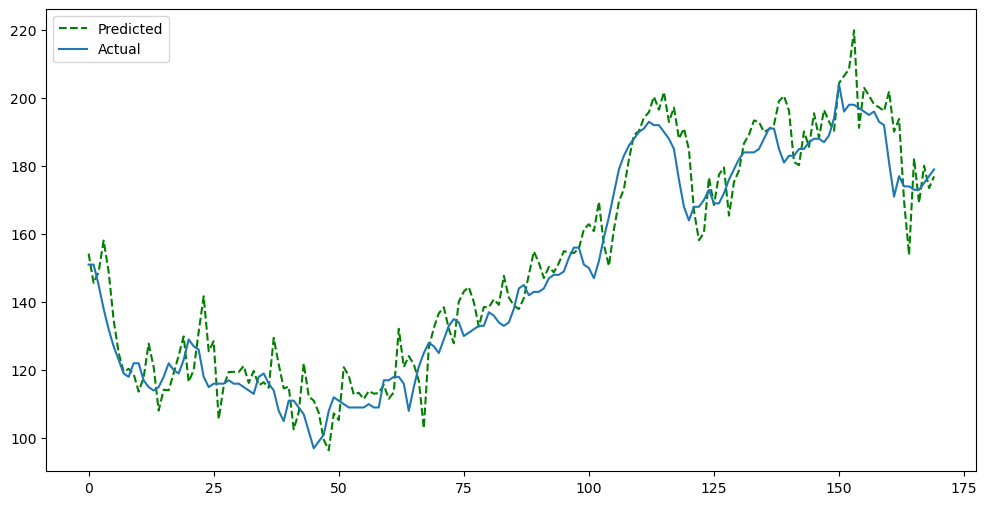

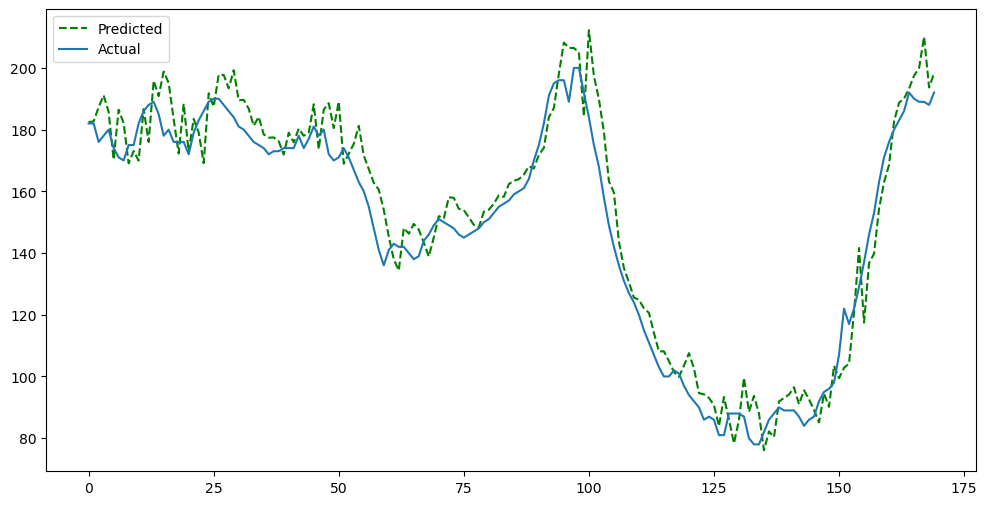

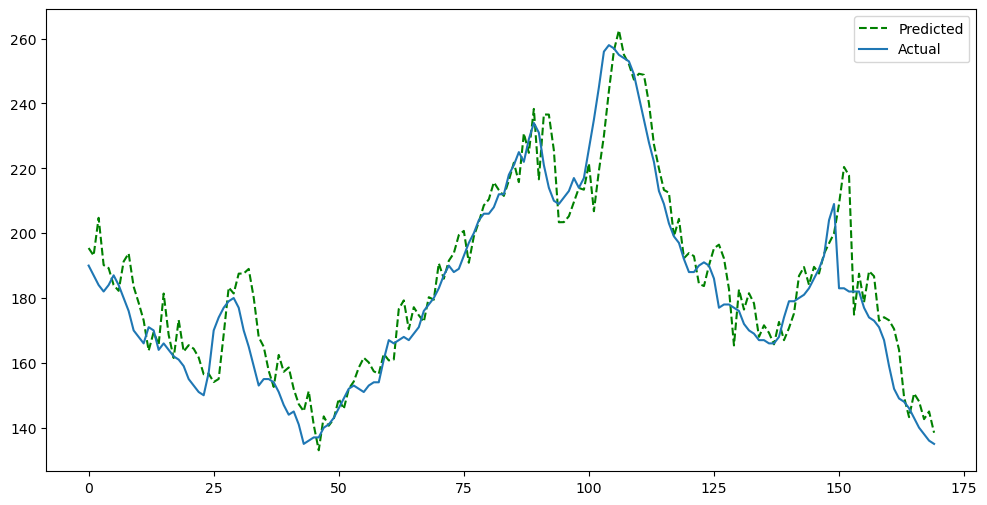

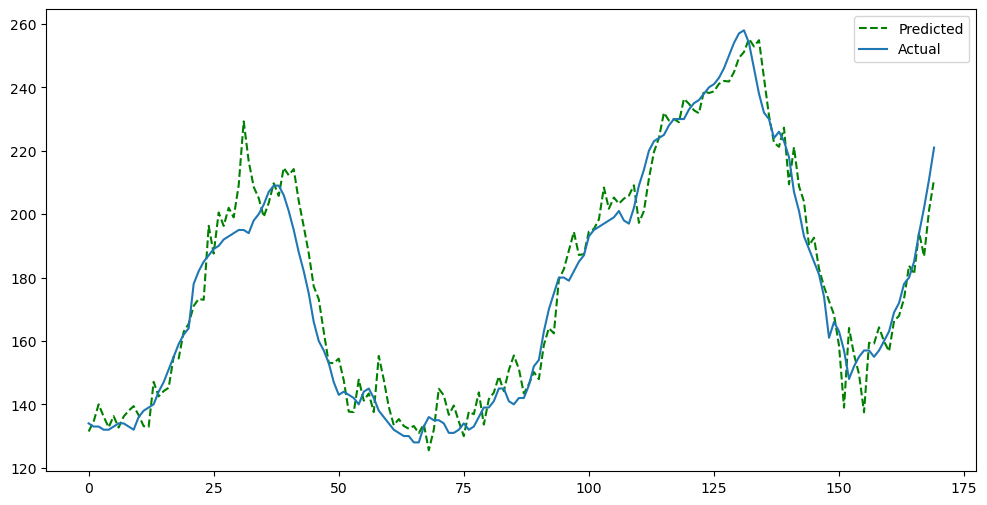

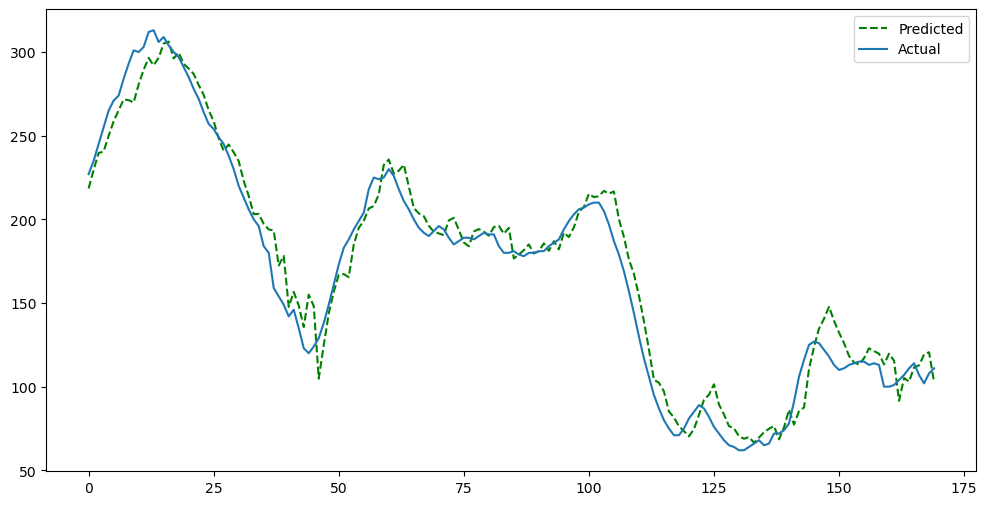

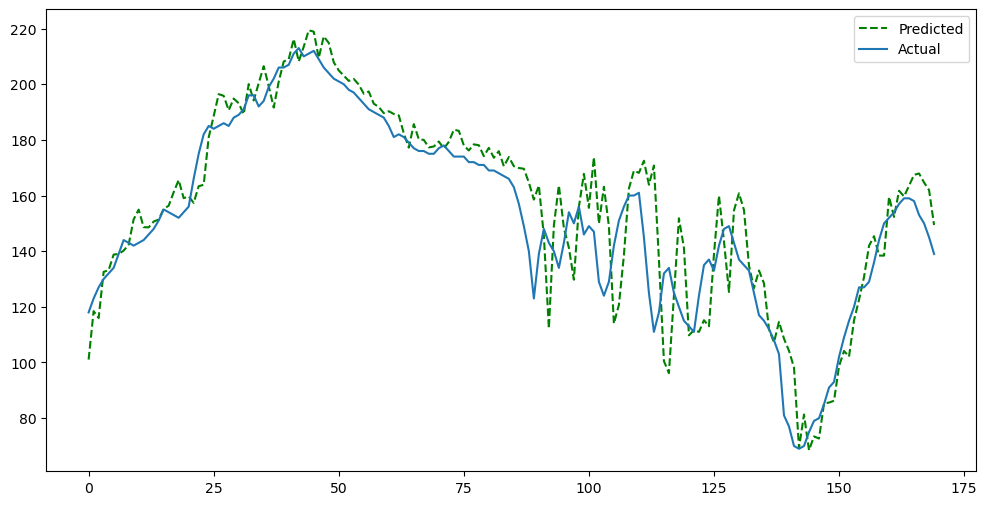

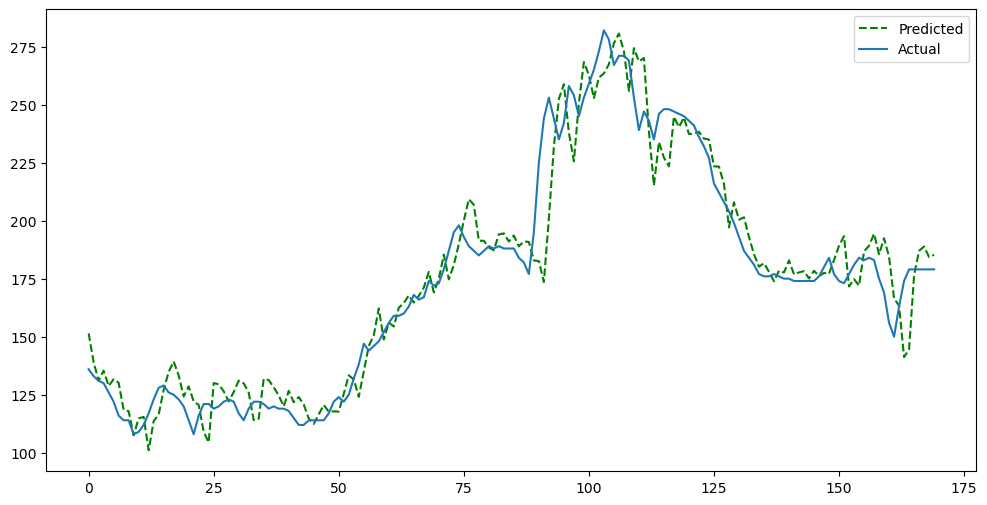

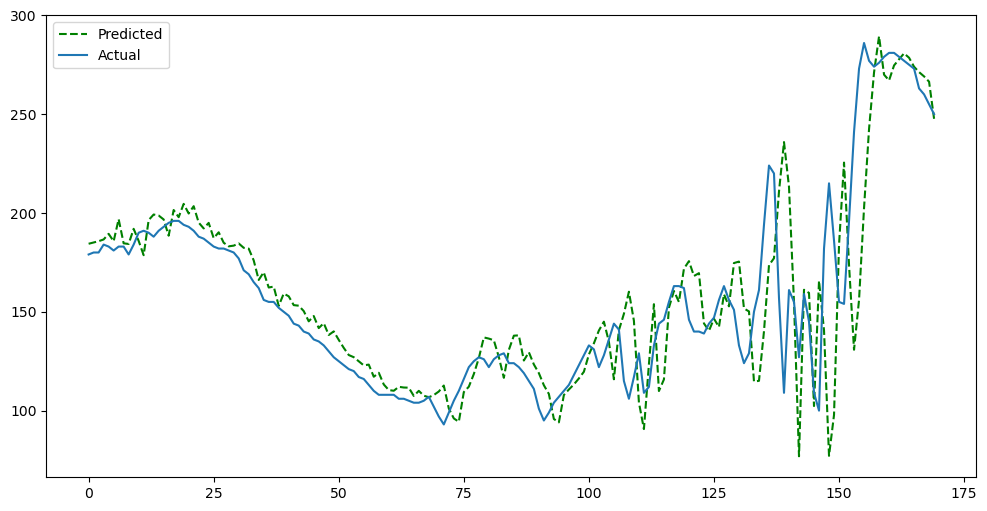

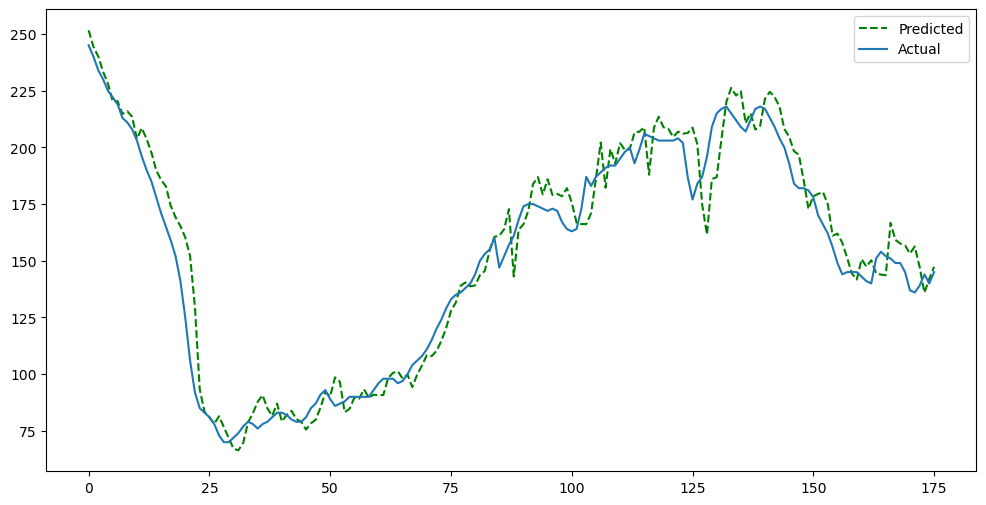

In [37]:
plot_model_predictions(test_lstm, fifteen_range, num_graphs=15)


In [116]:
data = train_588['GlucoseLevel']

In [117]:
data

ts
2021-08-30 11:55:00    116
2021-08-30 12:00:00    117
2021-08-30 12:05:00    119
2021-08-30 12:10:00    116
2021-08-30 12:15:00    111
                      ... 
2021-10-14 23:40:00    150
2021-10-14 23:45:00    144
2021-10-14 23:50:00    140
2021-10-14 23:55:00    137
2021-10-15 00:00:00    132
Name: GlucoseLevel, Length: 12640, dtype: int64

In [118]:
filtered = savgol_filter(data, 13, 4)

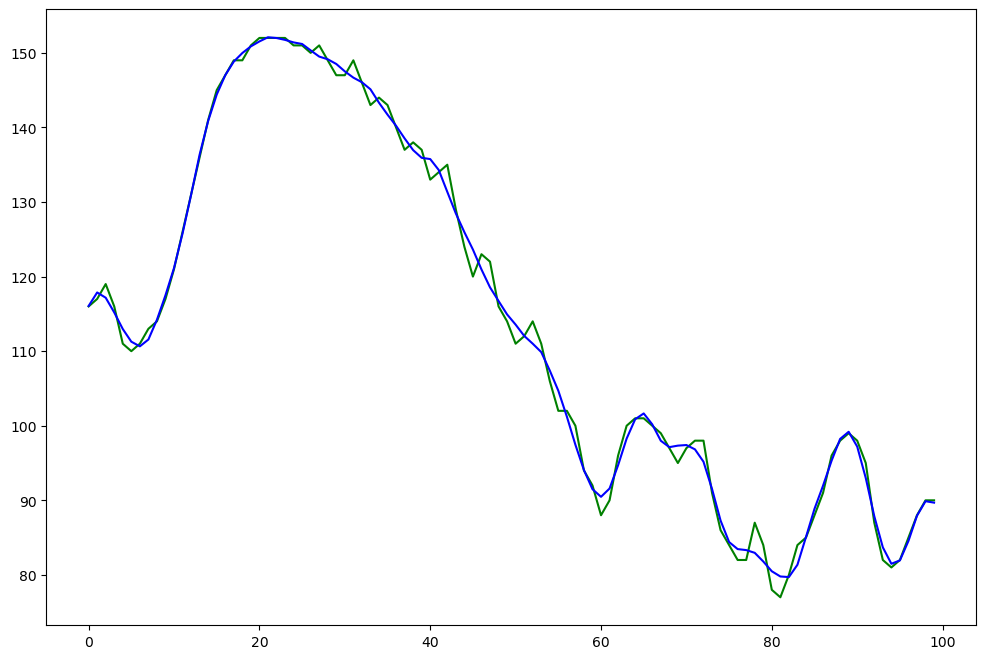

In [119]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(list(range(100)),data[0:100], c='g')
plt.plot(list(range(100)), filtered[0:100],c='b')

In [120]:
filtered = np.array(filtered)
filtered

array([116.06205559, 117.87071752, 117.16559911, ..., 139.83904331,
       135.53975436, 132.71784098])

In [121]:
data

ts
2021-08-30 11:55:00    116
2021-08-30 12:00:00    117
2021-08-30 12:05:00    119
2021-08-30 12:10:00    116
2021-08-30 12:15:00    111
                      ... 
2021-10-14 23:40:00    150
2021-10-14 23:45:00    144
2021-10-14 23:50:00    140
2021-10-14 23:55:00    137
2021-10-15 00:00:00    132
Name: GlucoseLevel, Length: 12640, dtype: int64

In [122]:
train_588['GlucoseLevel'] = filtered

In [128]:
fifteen_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 1,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(train_588['GlucoseLevel']),
    test_df=pd.DataFrame(test_588['GlucoseLevel'])
)

In [124]:
new_lstm = create_normal_lstm(1)

In [126]:
fit_model(new_lstm, fifteen_range_g, 40)

Epoch 1/40
395/395 [==============================] - 4s 8ms/step - loss: 71.8440 - root_mean_squared_error: 8.4761 - mean_absolute_error: 5.7438
Epoch 2/40
395/395 [==============================] - 4s 11ms/step - loss: 71.6296 - root_mean_squared_error: 8.4634 - mean_absolute_error: 5.7294
Epoch 3/40
395/395 [==============================] - 4s 11ms/step - loss: 71.5227 - root_mean_squared_error: 8.4571 - mean_absolute_error: 5.7894
Epoch 4/40
395/395 [==============================] - 4s 11ms/step - loss: 70.2273 - root_mean_squared_error: 8.3802 - mean_absolute_error: 5.7029
Epoch 5/40
395/395 [==============================] - 4s 11ms/step - loss: 69.6006 - root_mean_squared_error: 8.3427 - mean_absolute_error: 5.6606
Epoch 6/40
395/395 [==============================] - 4s 11ms/step - loss: 69.9532 - root_mean_squared_error: 8.3638 - mean_absolute_error: 5.6899
Epoch 7/40
395/395 [==============================] - 4s 11ms/step - loss: 69.7565 - root_mean_squared_error: 8.3520 - 

In [129]:
new_lstm.evaluate(fifteen_range_g.test)

87/87 [==============================] - 0s 4ms/step - loss: 38.3117 - root_mean_squared_error: 6.1896 - mean_absolute_error: 4.5344


[38.31167984008789, 6.189642906188965, 4.534449577331543]

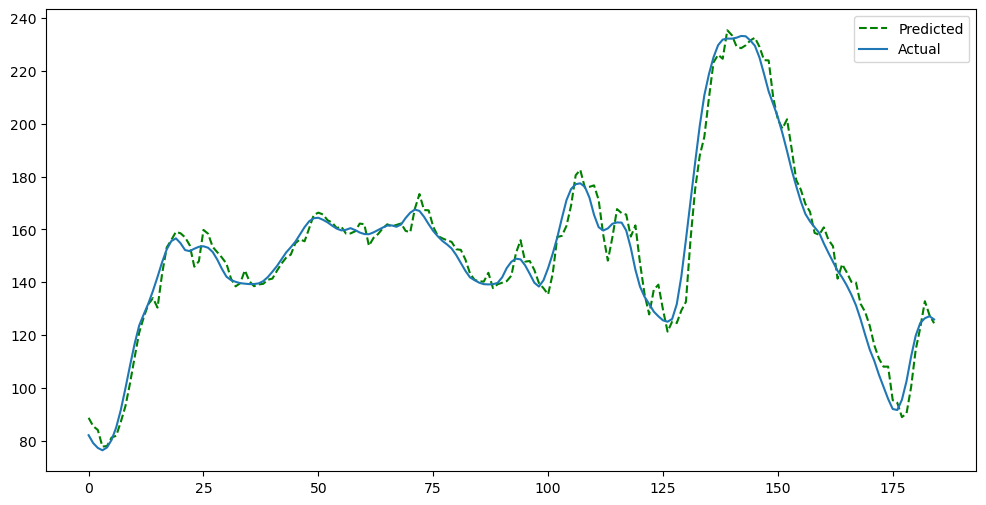

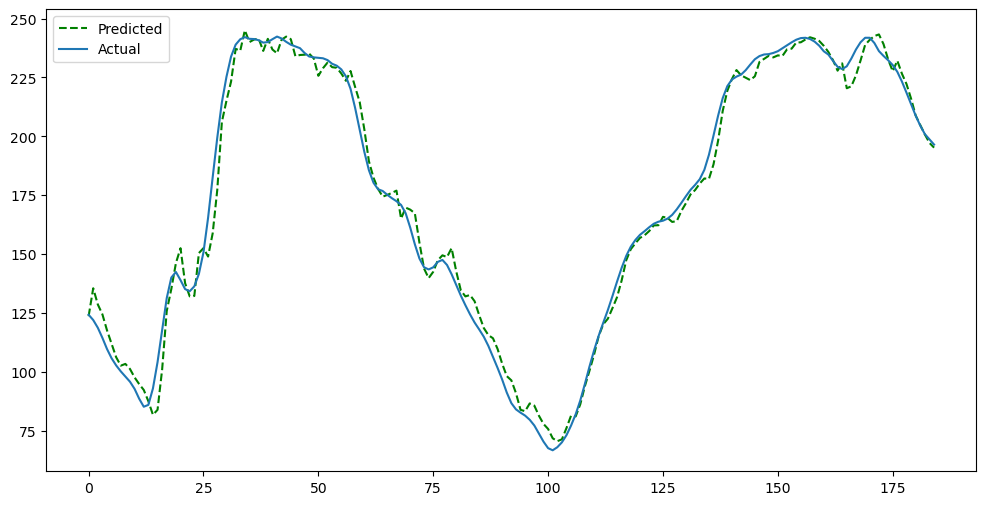

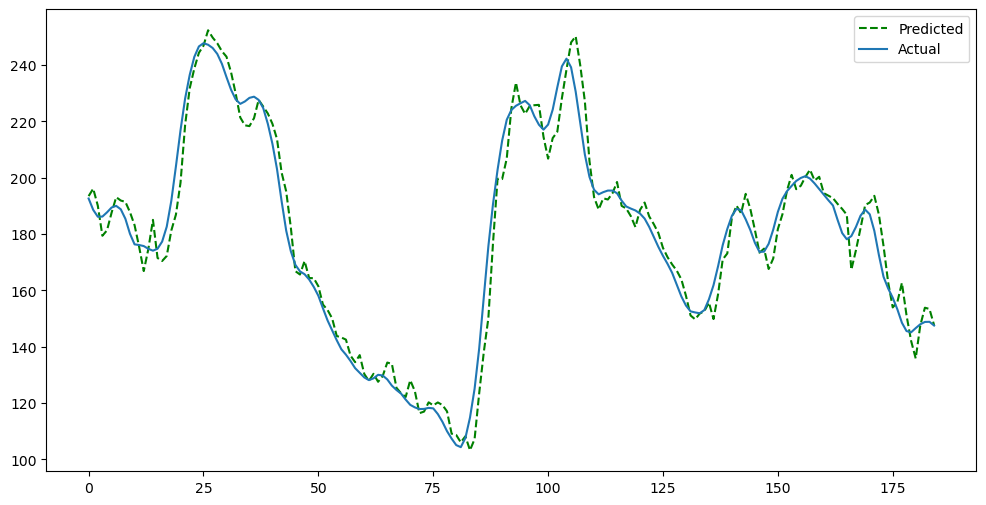

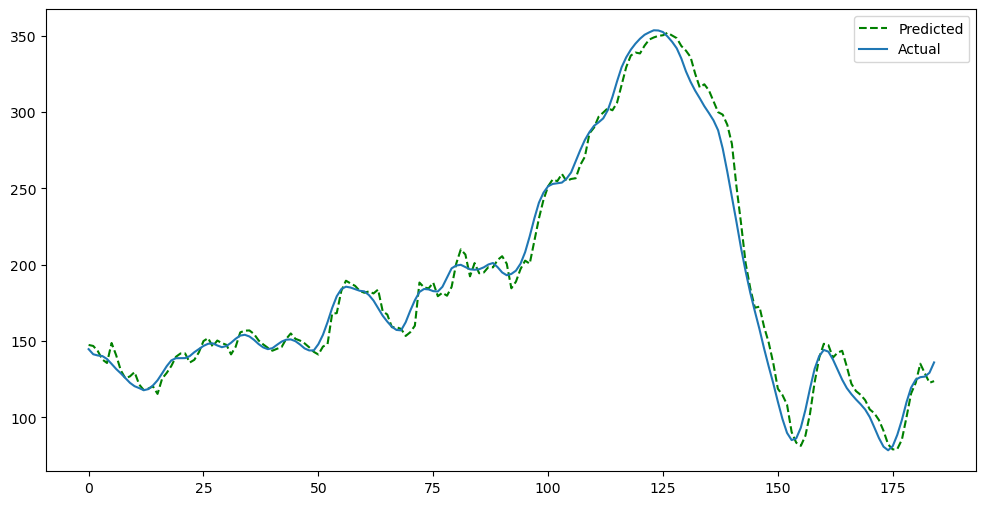

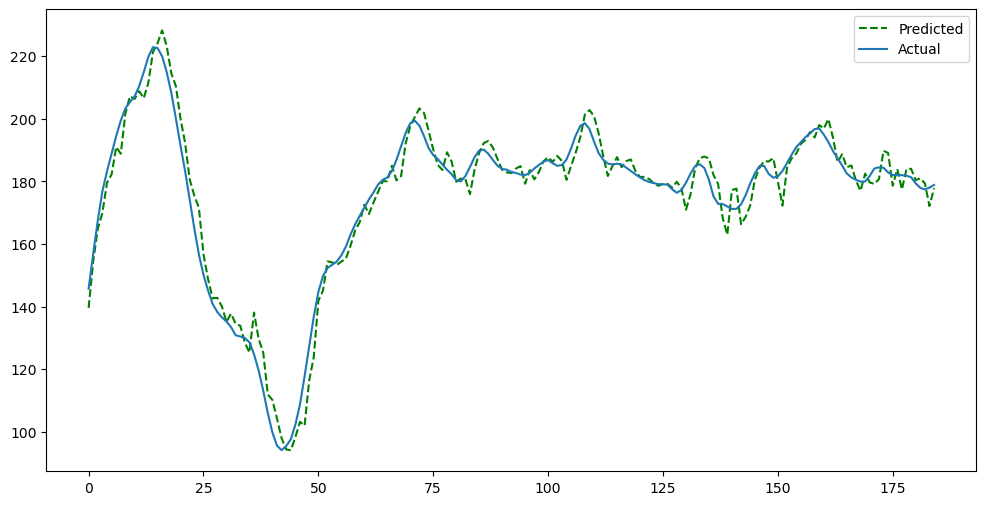

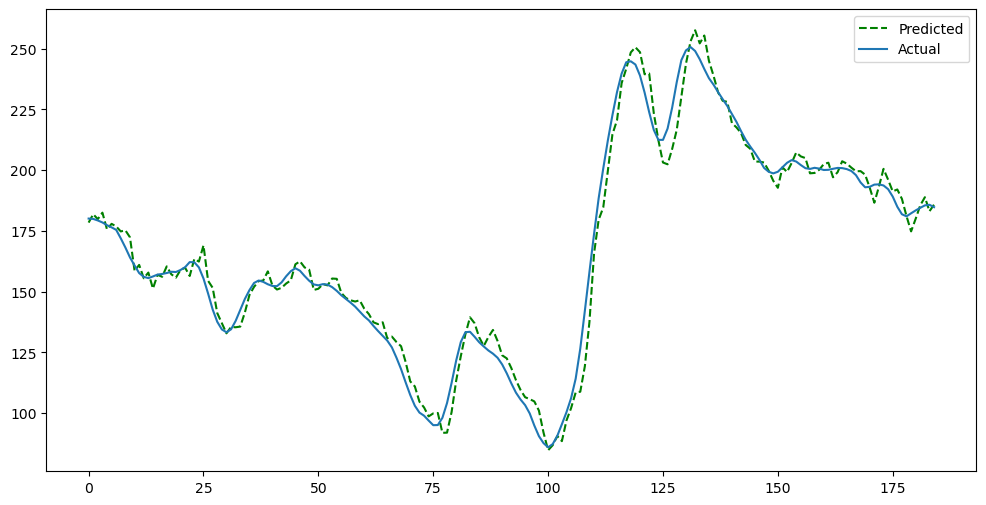

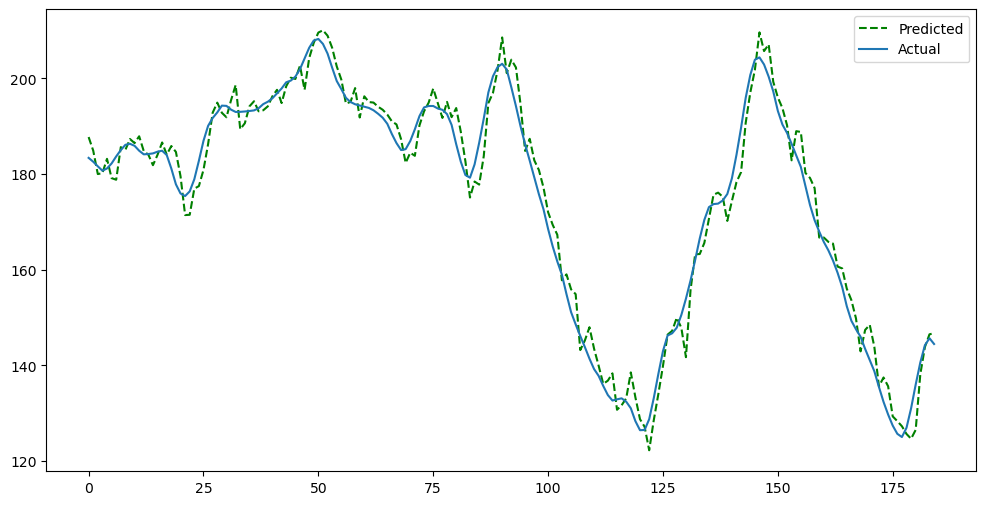

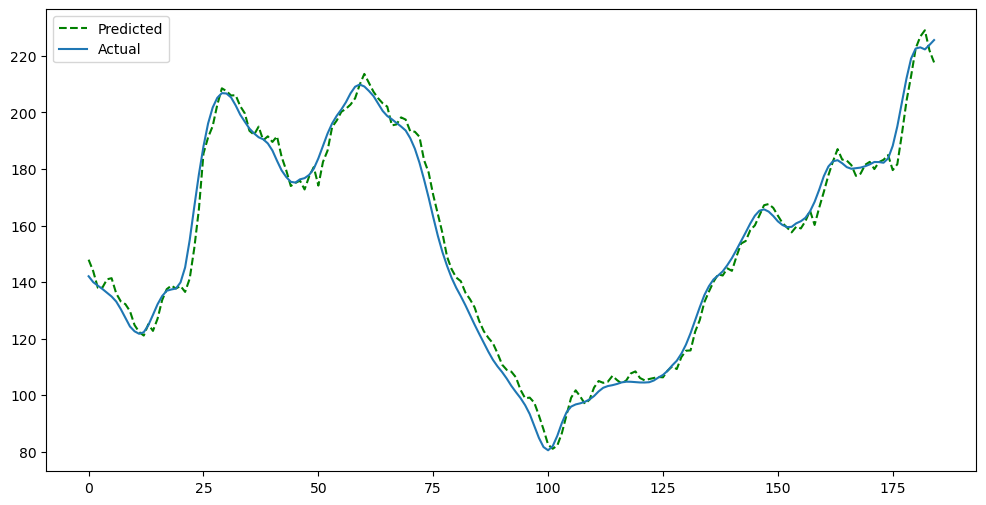

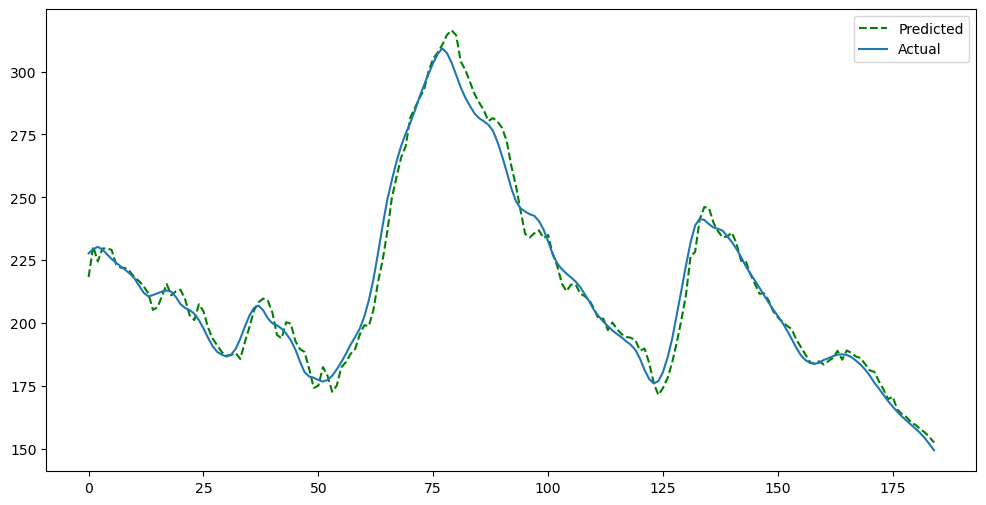

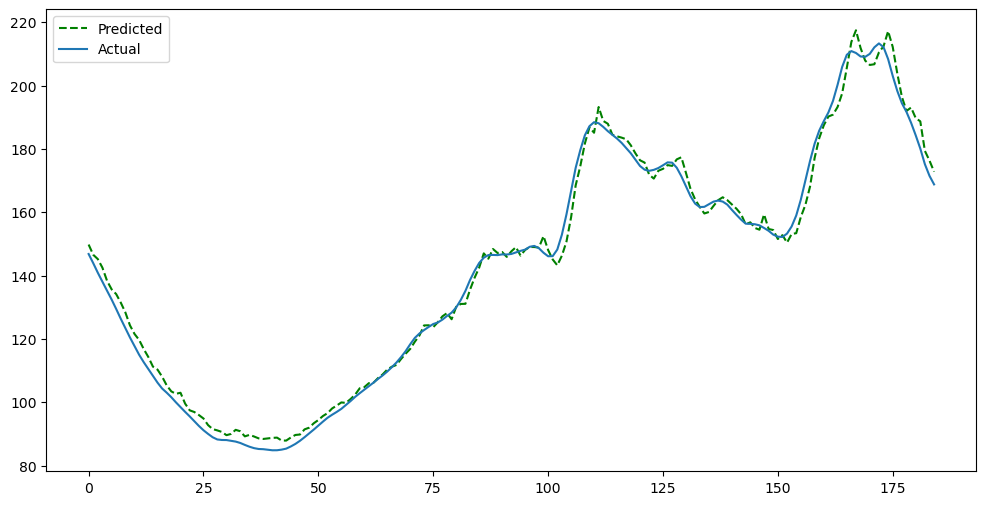

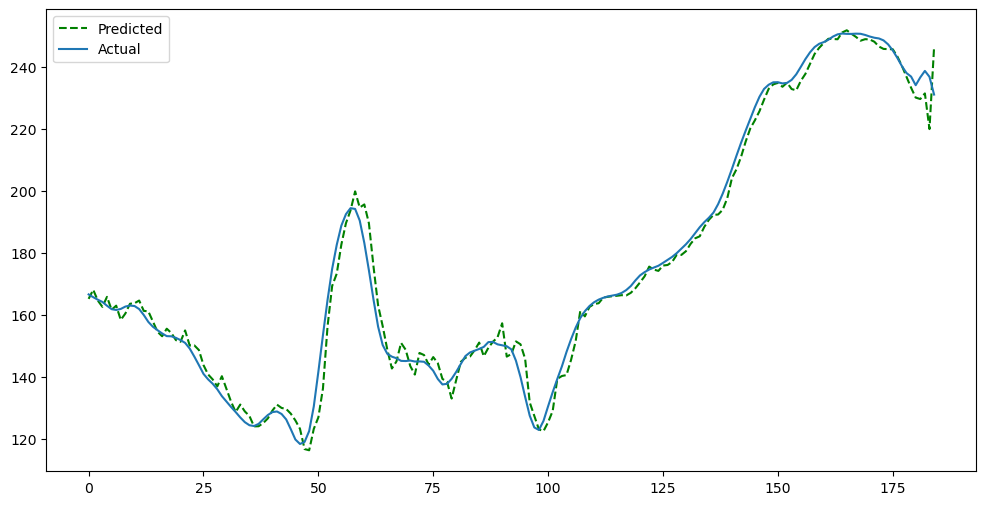

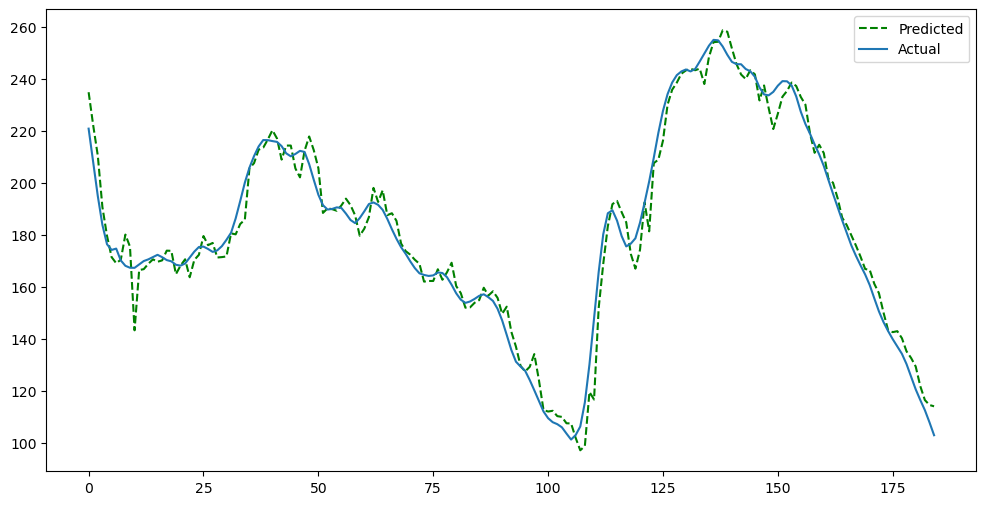

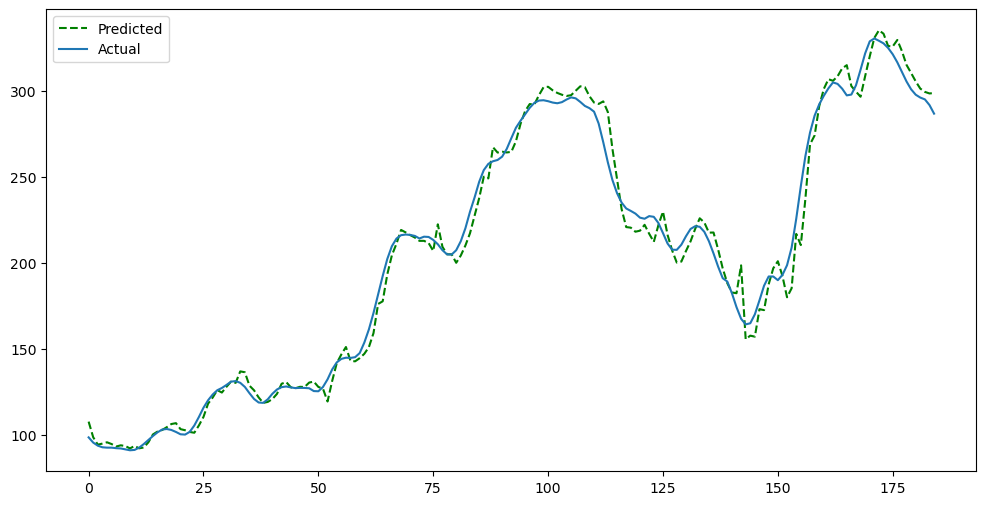

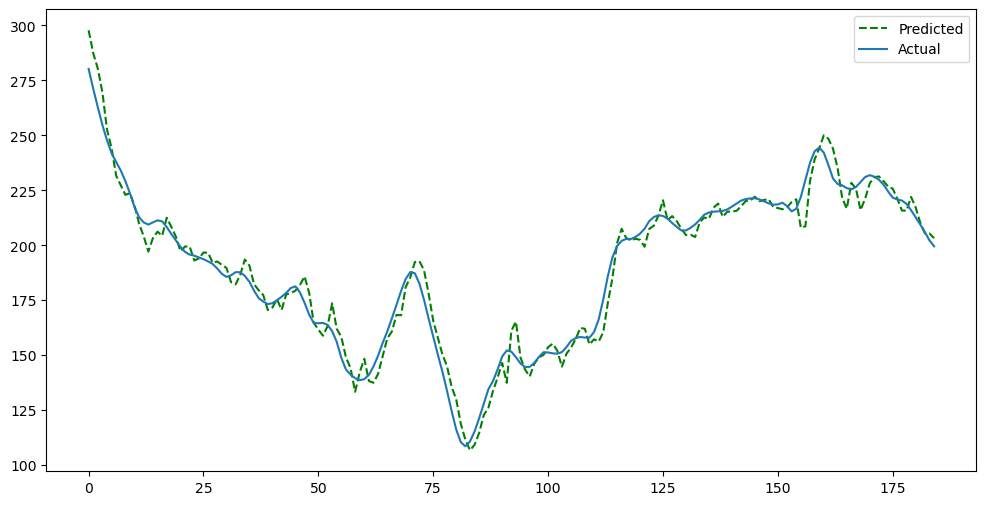

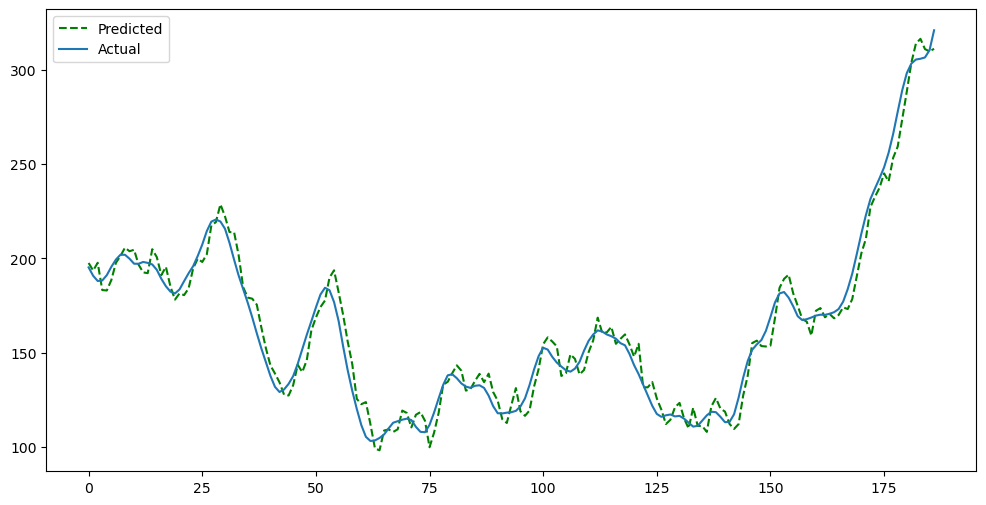

In [130]:
plot_model_predictions(new_lstm, fifteen_range_g, num_graphs=15)